# Task 2 Mitbih Data (LSTM-FCN,Encoder)

## Loading modules
Note we load models, data and plotting function from models.ipynb and helper_functions.ipynb

In [1]:
import itertools

In [2]:
import io
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import tensorflow as tf
import tensorflow_addons as tfa
from keras import losses
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from matplotlib import pyplot as plt
from pathlib import Path
from scipy import stats
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [3]:
%load_ext tensorboard
# For evaluation

## Load needed functions

### Models

In [4]:
# https://github.com/houshd/LSTM-FCN
# With adjsuted hyperaprameters
def LSTM_FCN(nclass, time_steps, features, af):

    inputs = keras.layers.Input([time_steps, features])

    x = keras.layers.Masking()(inputs)
    x = keras.layers.LSTM(128)(x)
    x = keras.layers.Dropout(0.8)(x)

    y = keras.layers.Permute((2, 1))(inputs)
    y = keras.layers.Conv1D(64, 8, padding='same',
                            kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Activation('relu')(y)

    y = keras.layers.Conv1D(128, 5, padding='same',
                            kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Activation('relu')(y)

    y = keras.layers.Conv1D(256, 3, padding='same',
                            kernel_initializer='he_uniform')(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Activation('relu')(y)

    y = keras.layers.GlobalAveragePooling1D()(y)

    x = keras.layers.concatenate([x, y])

    out = keras.layers.Dense(nclass, activation=af)(x)
    model = keras.Model(inputs, out)
    model.summary()
    return model


# https://www.cinc.org/archives/2020/pdf/CinC2020-227.pdf tried out different hyperparameters, but the one provided gave best results
def Encoder(nclass, time_steps, features, af):
    input_layer = keras.layers.Input(shape=(time_steps, features))

    # conv block -1
    conv1 = keras.layers.Conv1D(
        filters=160, kernel_size=5, strides=1, padding='same')(input_layer)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(
        filters=224, kernel_size=9, strides=1, padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(
        filters=256, kernel_size=9, strides=1, padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:, :, :128])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:, :, 128:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()(
        [attention_softmax, attention_data])
    # last layer
    dense_layer = keras.layers.Dense(
        units=2048, activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = keras.layers.Flatten()(dense_layer)
    output_layer = keras.layers.Dense(
        units=nclass, activation=af)(flatten_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

### Helper functions

In [5]:
def get_model(data, model_name):
    time_steps = 187
    features = 1
    if data == "mitbih":
        number_class = 5
        activation_function = "softmax"
        loss = losses.sparse_categorical_crossentropy
    elif data == "ptbdb":
        number_class = 1
        activation_function = "sigmoid"
        loss = losses.binary_crossentropy
    if model_name == "ResNet":
        np.expand_dims(X_train, -1)
        np.expand_dims(Y_train, -1)
        model = ResNet(number_class, time_steps, features, activation_function)
    elif model_name == "CNN":
        model = CNN(number_class, time_steps, features, activation_function)
    elif model_name == "CNNDML":
        model = CNNDML(number_class, time_steps, features, activation_function)
    elif model_name == "RNN":
        model = RNN(number_class, time_steps, features, activation_function)
    elif model_name == "RNNDML":
        model = RNNDML(number_class, time_steps, features, activation_function)
    elif model_name == "BaseLine":
        model = BaseLine(number_class, time_steps,
                         features, activation_function)

    elif model_name == "Transformer":
        model = Transformer(number_class, time_steps,
                            features, activation_function)
    elif model_name == "LSTM_FCN":
        model = LSTM_FCN(number_class, time_steps,
                         features, activation_function)
    elif model_name == "Encoder":
        model = Encoder(number_class, time_steps,
                        features, activation_function)
    elif model_name == "EncoderDML":
        model = EncoderDML(number_class, time_steps,
                           features, activation_function)
    elif model_name == "RNNAdvanced":
        model = RNNAdvanced(number_class, time_steps,
                            features, activation_function)
    elif model_name == "CNN2":
        model = CNN2(number_class, time_steps, features, activation_function)
    return model, loss


def get_data(data, data_path, zscore=True):
    if data == "mitbih":
        df_train = pd.read_csv(data_path+"/mitbih_train.csv", header=None)
        df_train = df_train.sample(frac=1)
        df_test = pd.read_csv(data_path+"/mitbih_test.csv", header=None)

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    elif data == "ptbdb":
        df_1 = pd.read_csv(data_path+"/ptbdb_normal.csv", header=None)
        df_2 = pd.read_csv(data_path+"/ptbdb_abnormal.csv", header=None)
        df = pd.concat([df_1, df_2])

        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1337, stratify=df[187])

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    if zscore:
        X = stats.zscore(X, axis=1)
        X_test = stats.zscore(X_test, axis=1)

    return X, X_test, Y, Y_test


def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    test_pred = model.predict(X_test)
    test_pred = np.argmax(test_pred, axis=-1)
    classes = [*mitbih_dict]
    cm = metrics.confusion_matrix(Y_test, test_pred)
    normalize = True
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(model_name+" Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the confusion matrix as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)


def plot_confusion_matrix(
    y_true,
    y_pred,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)
    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


def plot_model_results(model, history, model_path, data, model_name, X_test, Y_test):
    model.load_weights(model_path)
    if model_name == "ResNet":
        X_test = np.expand_dims(X_test, -1)
        Y_test = np.expand_dims(Y_test, -1)
        model.evaluate(X_test, Y_test)
    if data == "mitbih":
        mitbih_dict = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
        pred_test = model.predict(X_test)
        pred_test = np.argmax(pred_test, axis=-1)

        pd.DataFrame(history.history).plot(figsize=(8, 5))

        f1 = f1_score(Y_test, pred_test, average="macro")
        acc = accuracy_score(Y_test, pred_test)

        print("Test F1 score : {:.4f}".format(np.mean(f1)))
        print("Test ACC score : {:.4f}".format(np.mean(acc)))

        plot_confusion_matrix(
            Y_test,
            pred_test,
            [*mitbih_dict],
            normalize=True,
            title="Confusion matrix",
            cmap=plt.cm.Blues)
    elif data == "ptbdb":
        ptbdb_dict = {'Normal': 0, 'Abnormal': 1}
        pred_test = model.predict(X_test)
        pred_test = (pred_test > 0.5).astype(np.int8)
        f1 = f1_score(Y_test, pred_test, average="macro")
        acc = accuracy_score(Y_test, pred_test)
        print("Test F1 score : {:.4f}".format(np.mean(f1)))
        print("Test ACC score : {:.4f}".format(np.mean(acc)))
        plot_confusion_matrix(
            Y_test,
            pred_test,
            [*ptbdb_dict],
            normalize=False,
            title="Confusion matrix",
            cmap=plt.cm.Blues)
        plot_roc(Y_test, pred_test)
        plot_precisionrecall(Y_test, pred_test)

#### Define path, where data is stored and where you want the models and results stored!

In [6]:
working_path = pathlib.Path().resolve()
path_object = Path(working_path)
parent_path = path_object.parent
model_path_parent = os.path.join(parent_path, "03-Models/02-Mitbih/02-Task2")
data_path = os.path.join(parent_path, "01-Data")
tensorboard_path_parent = os.path.join(
    parent_path, "04-Logs/02-Mitbih/02-Task2")

## LSTM-FCN
### Compile and run

In [7]:
# Always clear as keras backend is tedious
tf.keras.backend.clear_session()

# Load the prefered Model and data which will be feeded
data = "mitbih"
model_name = "LSTM_FCN"
model, loss = get_model(data, model_name)

# will be z-Scored
X_train, X_test, Y_train, Y_test = get_data(data, data_path, zscore=True)
mitbih_dict = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}

# Define Hyperparameters
epochs = 40
learning_rate = 0.0001
batch_size = 128
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = loss


# Define Callbacks (taken from baseline file)
model_path = os.path.join(model_path_parent, model_name+"_"+data+"_weights.h5")
tensorboard_path = os.path.join(tensorboard_path_parent, model_name+"_"+data)
file_writer = tf.summary.create_file_writer(tensorboard_path)


checkpoint = ModelCheckpoint(
    model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy",
                      mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(
    monitor="val_accuracy", mode="max", patience=3, verbose=2)
# uncomment if you want to track in tensorboard
tbc = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
callbacks_list = [
    checkpoint,
    early,
    redonplat,
    tbc,
    cm_callback,
]

# delete tensorboard folder if already exists, so no overlap
try:
    shutil.rmtree(tensorboard_path)
except:
    pass

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 1, 187)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 1, 64)        95808       ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1, 64)       256         ['conv1d[0][0]']                 
 alization)                                                                                   

In [8]:
# Compile and Run
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_split=0.1, epochs=epochs,
                    shuffle=True, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/40
616/616 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.8882
Epoch 1: val_accuracy improved from -inf to 0.95420, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/02-Task2\LSTM_FCN_mitbih_weights.h5
616/616 [==============================] - 36s 45ms/step - loss: 0.3654 - accuracy: 0.8882 - val_loss: 0.1698 - val_accuracy: 0.9542 - lr: 1.0000e-04
Epoch 2/40
614/616 [============================>.] - ETA: 0s - loss: 0.1663 - accuracy: 0.9556
Epoch 2: val_accuracy improved from 0.95420 to 0.96437, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/02-Task2\LSTM_FCN_mitbih_weights.h5
616/616 [==============================] - 25s 40ms/step - loss: 0.1664 - accuracy: 0.9556 - val_loss: 0.1331 - val_accuracy: 0.9644 - lr: 1.0000e-04
Epoch 3/40
615/616 [============================>.] - ETA: 0s - loss: 0.1316 - accuracy: 0.9638
Epoch 3: val_accuracy improved from 0.96437 to 0.96

### Results LSTM-FCN

Test F1 score : 0.8884
Test ACC score : 0.9788
Normalized confusion matrix
[[9.94149465e-01 2.48371785e-03 2.20774920e-03 3.31162380e-04
  8.27905950e-04]
 [3.00359712e-01 6.78057554e-01 1.97841727e-02 0.00000000e+00
  1.79856115e-03]
 [4.62707182e-02 2.07182320e-03 9.38535912e-01 1.10497238e-02
  2.07182320e-03]
 [1.97530864e-01 0.00000000e+00 1.04938272e-01 6.97530864e-01
  0.00000000e+00]
 [2.23880597e-02 6.21890547e-04 3.10945274e-03 0.00000000e+00
  9.73880597e-01]]


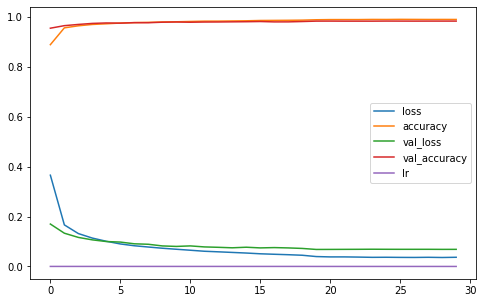

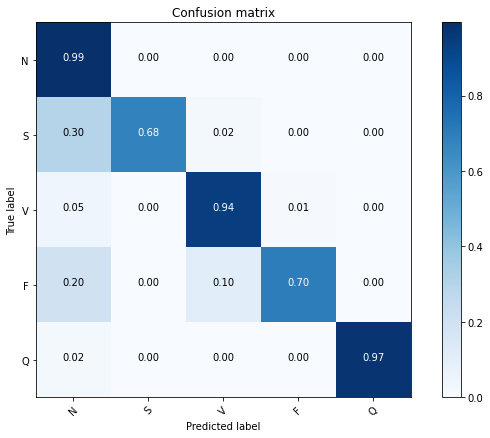

In [9]:
plot_model_results(model, history, model_path,
                   data, model_name, X_test, Y_test)

In [10]:
model_path = os.path.join(model_path_parent, model_name+"_"+data)
model.save(model_path)

INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/02-Task2\LSTM_FCN_mitbih\assets


INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/02-Task2\LSTM_FCN_mitbih\assets


## Encoder
### Compile and run

In [11]:
# Always clear as keras backend is tedious
tf.keras.backend.clear_session()

# Load the prefered Model and data which will be feeded
data = "mitbih"
model_name = "Encoder"
model, loss = get_model(data, model_name)

# will be z-Scored
X_train, X_test, Y_train, Y_test = get_data(data, data_path, zscore=True)
mitbih_dict = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}

# Define Hyperparameters
epochs = 40
learning_rate = 0.0001
batch_size = 128
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = loss


# Define Callbacks (taken from baseline file)
model_path = os.path.join(model_path_parent, model_name+"_"+data+"_weights.h5")
tensorboard_path = os.path.join(tensorboard_path_parent, model_name+"_"+data)
file_writer = tf.summary.create_file_writer(tensorboard_path)


checkpoint = ModelCheckpoint(
    model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy",
                      mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(
    monitor="val_accuracy", mode="max", patience=3, verbose=2)
# uncomment if you want to track in tensorboard
tbc = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
callbacks_list = [
    checkpoint,
    early,
    redonplat,
    tbc,
    cm_callback,
]

# delete tensorboard folder if already exists, so no overlap
try:
    shutil.rmtree(tensorboard_path)
except:
    pass

In [12]:
# Compile and Run
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_split=0.1, epochs=epochs,
                    shuffle=True, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/40
616/616 [==============================] - ETA: 0s - loss: 0.1795 - accuracy: 0.9514
Epoch 1: val_accuracy improved from -inf to 0.97339, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/02-Task2\Encoder_mitbih_weights.h5
616/616 [==============================] - 29s 45ms/step - loss: 0.1795 - accuracy: 0.9514 - val_loss: 0.0971 - val_accuracy: 0.9734 - lr: 1.0000e-04
Epoch 2/40
615/616 [============================>.] - ETA: 0s - loss: 0.1003 - accuracy: 0.9722
Epoch 2: val_accuracy improved from 0.97339 to 0.97442, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/02-Task2\Encoder_mitbih_weights.h5
616/616 [==============================] - 27s 44ms/step - loss: 0.1004 - accuracy: 0.9722 - val_loss: 0.0851 - val_accuracy: 0.9744 - lr: 1.0000e-04
Epoch 3/40
615/616 [============================>.] - ETA: 0s - loss: 0.0826 - accuracy: 0.9764
Epoch 3: val_accuracy improved from 0.97442 to 0.9803

Epoch 23/40
615/616 [============================>.] - ETA: 0s - loss: 0.0198 - accuracy: 0.9933
Epoch 23: val_accuracy did not improve from 0.98847
616/616 [==============================] - 27s 44ms/step - loss: 0.0198 - accuracy: 0.9933 - val_loss: 0.0406 - val_accuracy: 0.9884 - lr: 1.0000e-05
Epoch 24/40
615/616 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9935
Epoch 24: val_accuracy did not improve from 0.98847
616/616 [==============================] - 27s 44ms/step - loss: 0.0200 - accuracy: 0.9935 - val_loss: 0.0422 - val_accuracy: 0.9885 - lr: 1.0000e-05
Epoch 25/40
615/616 [============================>.] - ETA: 0s - loss: 0.0192 - accuracy: 0.9936
Epoch 25: val_accuracy did not improve from 0.98847

Epoch 25: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
616/616 [==============================] - 27s 44ms/step - loss: 0.0192 - accuracy: 0.9937 - val_loss: 0.0401 - val_accuracy: 0.9884 - lr: 1.0000e-05
Epoch 26/40
615/616 [====

### Results Encoder

Test F1 score : 0.9203
Test ACC score : 0.9869
Normalized confusion matrix
[[9.97571476e-01 1.37984325e-03 8.27905950e-04 1.65581190e-04
  5.51937300e-05]
 [2.06834532e-01 7.84172662e-01 7.19424460e-03 0.00000000e+00
  1.79856115e-03]
 [2.34806630e-02 3.45303867e-03 9.61325967e-01 9.66850829e-03
  2.07182320e-03]
 [1.85185185e-01 0.00000000e+00 8.64197531e-02 7.28395062e-01
  0.00000000e+00]
 [1.43034826e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.85696517e-01]]


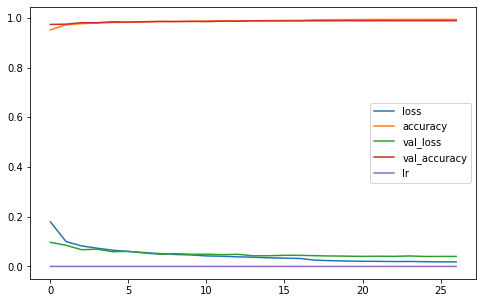

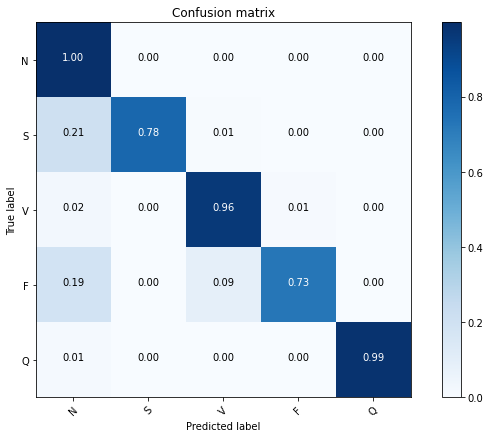

In [13]:
plot_model_results(model, history, model_path,
                   data, model_name, X_test, Y_test)

In [14]:
model_path = os.path.join(model_path_parent, model_name+"_"+data)
model.save(model_path)

INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/02-Task2\Encoder_mitbih\assets


INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/02-Task2\Encoder_mitbih\assets


In [15]:
## Visualizaitons in tensorboard

In [16]:
# Please have a look at in Tensorboard with all needed figures,
# change mode to light on half-moon icon to see labels and move circle above cm to see evolution for each epoch
# You can also look at the results in your browser, see tensorboard documentation

# At parent path, so both Results are compared to each other
%tensorboard --logdir {tensorboard_path_parent.replace(os.sep, '/')}

## Results